In [1]:
import COVID19Py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats
from datetime import datetime
from datetime import timedelta  

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import operator

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

In [2]:
covid19 = COVID19Py.COVID19()

In [3]:
latest = covid19.getLatest()
latest

{'confirmed': 782365, 'deaths': 37582, 'recovered': 0}

In [4]:
def normatize_cases_by_absolute_day(df):
    
    days = []
    cases = []
    dates = []
    deaths = []
    recovereds = []
    contagious = []
    current_day = 0
    
    for i in range(df.shape[0]):
        if df.iloc[i].Cases > 0:
            current_day = current_day+1
            days.append(current_day)
            cases.append(df.iloc[i].Cases)
            datetime_object = datetime.strptime(str(df.iloc[i].Date), '%Y-%m-%dT%H:%M:%SZ')
            dates.append(datetime_object)
            deaths.append(df.iloc[i].Deaths)
            recovereds.append(df.iloc[i].Recovered)
            contagious.append(df.iloc[i].Contagious)
    df = pd.DataFrame({"Date":dates, "Day":days, "Cases": cases, "Deaths": deaths, "Recovered": recovereds, "Contagious": contagious})
    return df

def contagious_dataframe(df):
    contagious_list = []
    for x in range(df.shape[0]):
        if x == 0:
            contagious_list.append(0)
        if (x+1) < df.shape[0]:
            cases_sub = df.iloc[(x+1)].Cases - df.iloc[x].Cases
            contagious_list.append(cases_sub)
    df = pd.DataFrame({'Contagious': contagious_list})
    return df 

def data_consolidation(data):
    
    confirmed_dict = {}
    deaths_dict = {}
    recovered_dict = {}
    
    for i in range(len(data)):
        confirmed = data[i]['timelines']['confirmed']['timeline']
        deaths = data[i]['timelines']['deaths']['timeline']
        recovered = data[i]['timelines']['recovered']['timeline']
        for key in confirmed:
            if i == 0:
                confirmed_dict[key] = confirmed[key]
            else:
                confirmed_dict[key] = confirmed_dict[key]+confirmed[key]
        for key in deaths:
            if i == 0:
                deaths_dict[key] = deaths[key]
            else:
                deaths_dict[key] = deaths_dict[key]+deaths[key]
        for key in recovered:
            if i == 0:
                recovered_dict[key] = recovered[key]
            else:
                recovered_dict[key] = recovered_dict[key]+recovered[key]
                
    return confirmed_dict, deaths_dict, recovered_dict
            

In [5]:
no_catalog_cases_china = pd.read_csv(r'china_no_catalog_cases.csv', delimiter=";", header=None)
no_catalog_cases_china.columns = ['Date', 'Cases']

no_catalog_cases_china_deaths_recovered = pd.read_csv(r'china_no_catalog_cases_deaths_recovered.csv', delimiter=";", header=None)
no_catalog_cases_china_deaths_recovered.columns = ['Date', 'Cases']

In [6]:
brazil_confirmed_dict, brazil_deaths_dict, brazil_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("BR", timelines=True))
japan_confirmed_dict, japan_deaths_dict, japan_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("JP", timelines=True))
china_confirmed_dict, china_deaths_dict, china_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("CN", timelines=True))
south_korea_confirmed_dict, south_korea_deaths_dict, south_korea_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("KR", timelines=True))
italy_confirmed_dict, italy_deaths_dict, italy_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("IT", timelines=True))
us_confirmed_dict, us_deaths_dict, us_recovered_dict = data_consolidation(covid19.getLocationByCountryCode("US", timelines=True))


dfBrazilConfirmedRaw = pd.DataFrame(brazil_confirmed_dict.items(), columns=['Date', 'Cases'])
dfJapanConfirmedRaw = pd.DataFrame(japan_confirmed_dict.items(), columns=['Date', 'Cases'])
dfChinaConfirmedRaw = pd.DataFrame(china_confirmed_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaConfirmedRaw = pd.DataFrame(south_korea_confirmed_dict.items(), columns=['Date', 'Cases'])
dfItalyConfirmedRaw = pd.DataFrame(italy_confirmed_dict.items(), columns=['Date', 'Cases'])
dfUsConfirmedRaw = pd.DataFrame(us_confirmed_dict.items(), columns=['Date', 'Cases'])

dfBrazilDeathsRaw = pd.DataFrame(brazil_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfJapanDeathsRaw = pd.DataFrame(japan_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfChinaDeathsRaw = pd.DataFrame(china_deaths_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaDeathsRaw = pd.DataFrame(south_korea_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfItalyDeathsRaw = pd.DataFrame(italy_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfUsDeathsRaw = pd.DataFrame(us_deaths_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)

dfBrazilRecoveredRaw = pd.DataFrame(brazil_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfJapanRecoveredRaw = pd.DataFrame(japan_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfChinaRecoveredRaw = pd.DataFrame(china_recovered_dict.items(), columns=['Date', 'Cases'])
dfSouthKoreaRecoveredRaw = pd.DataFrame(south_korea_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfItalyRecoveredRaw = pd.DataFrame(italy_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)
dfUsRecoveredRaw = pd.DataFrame(us_recovered_dict.items(), columns=['Date', 'Cases']).drop(["Date"], axis=1)


dfChinaConfirmedRaw = pd.concat([no_catalog_cases_china, dfChinaConfirmedRaw], ignore_index=True)
dfChinaDeathsRaw = pd.concat([no_catalog_cases_china_deaths_recovered, dfChinaDeathsRaw], ignore_index=True).drop(["Date"], axis=1)
dfChinaRecoveredRaw = pd.concat([no_catalog_cases_china_deaths_recovered, dfChinaRecoveredRaw], ignore_index=True).drop(["Date"], axis=1)


dfBrazilContagiousRaw = contagious_dataframe(dfBrazilConfirmedRaw)
dfJapanContagiousRaw = contagious_dataframe(dfJapanConfirmedRaw)
dfChinaContagiousRaw = contagious_dataframe(dfChinaConfirmedRaw)
dfSouthKoreaContagiousRaw = contagious_dataframe(dfSouthKoreaConfirmedRaw)
dfItalyContagiousRaw = contagious_dataframe(dfItalyConfirmedRaw)
dfUsContagiousRaw = contagious_dataframe(dfUsConfirmedRaw)

In [7]:
dfBrazilRaw = pd.concat(
    [dfBrazilConfirmedRaw,dfBrazilDeathsRaw, dfBrazilRecoveredRaw, dfBrazilContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfJapanRaw = pd.concat(
    [dfJapanConfirmedRaw,dfJapanDeathsRaw, dfJapanRecoveredRaw, dfJapanContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfChinaRaw = pd.concat(
    [dfChinaConfirmedRaw,dfChinaDeathsRaw, dfChinaRecoveredRaw, dfChinaContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfSouthKoreaRaw = pd.concat(
    [dfSouthKoreaConfirmedRaw,dfSouthKoreaDeathsRaw, dfSouthKoreaRecoveredRaw, dfSouthKoreaContagiousRaw], 
    ignore_index=True, 
    axis=1
)

dfItalyRaw = pd.concat(
    [dfItalyConfirmedRaw,dfItalyDeathsRaw, dfItalyRecoveredRaw, dfItalyContagiousRaw], 
    ignore_index=True, 
    axis=1
)
dfUsRaw = pd.concat(
    [dfUsConfirmedRaw,dfUsDeathsRaw, dfUsRecoveredRaw, dfUsContagiousRaw], 
    ignore_index=True, 
    axis=1
)

dfBrazilRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfJapanRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfChinaRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfSouthKoreaRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfItalyRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']
dfUsRaw.columns = ['Date', 'Cases', 'Deaths', 'Recovered', 'Contagious']


In [8]:
dfBrazil = normatize_cases_by_absolute_day(dfBrazilRaw)
dfJapan = normatize_cases_by_absolute_day(dfJapanRaw)
dfChina = normatize_cases_by_absolute_day(dfChinaRaw)
dfSouthKorea = normatize_cases_by_absolute_day(dfSouthKoreaRaw)
dfItaly = normatize_cases_by_absolute_day(dfItalyRaw)
dfUs = normatize_cases_by_absolute_day(dfUsRaw)

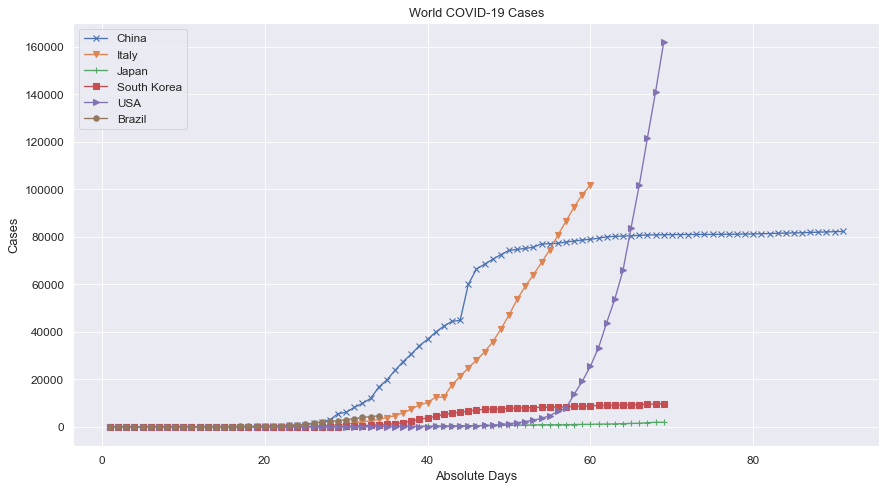

In [9]:
plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Cases, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Cases, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Cases, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Cases, "-s", label="South Korea")
plt.plot(dfUs.Day, dfUs.Cases, "->", label="USA")
plt.plot(dfBrazil.Day, dfBrazil.Cases, "-o", label="Brazil")
plt.title("World COVID-19 Cases")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()

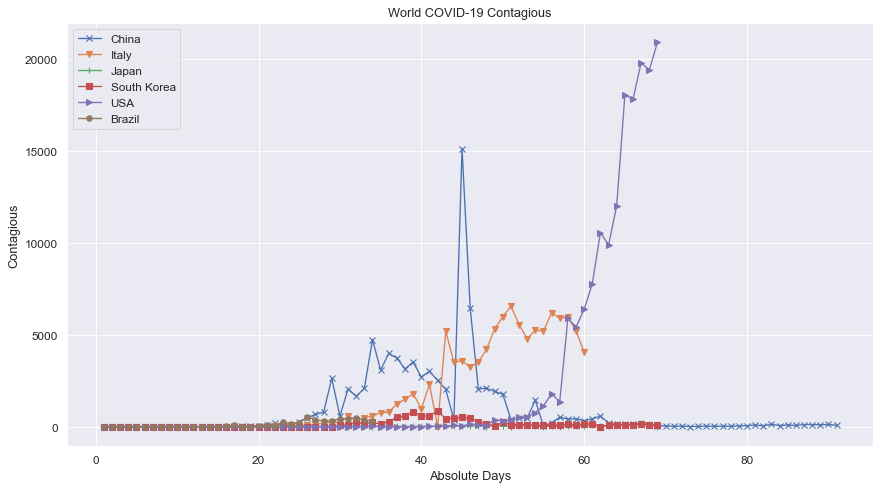

In [10]:
plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Contagious, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Contagious, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Contagious, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Contagious, "-s", label="South Korea")
plt.plot(dfUs.Day, dfUs.Contagious, "->", label="USA")
plt.plot(dfBrazil.Day, dfBrazil.Contagious, "-o", label="Brazil")
plt.title("World COVID-19 Contagious")
plt.xlabel("Absolute Days")
plt.ylabel("Contagious")
plt.legend(loc="upper left")
plt.show()

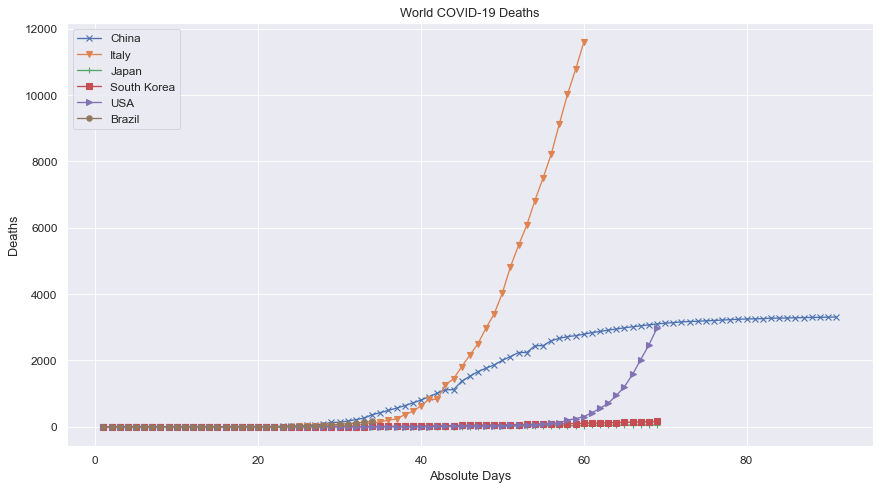

In [11]:
plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfChina.Day, dfChina.Deaths, "-x", label="China")
plt.plot(dfItaly.Day, dfItaly.Deaths, "-v", label="Italy")
plt.plot(dfJapan.Day, dfJapan.Deaths, "-+", label="Japan")
plt.plot(dfSouthKorea.Day, dfSouthKorea.Deaths, "-s", label="South Korea")
plt.plot(dfUs.Day, dfUs.Deaths, "->", label="USA")
plt.plot(dfBrazil.Day, dfBrazil.Deaths, "-o", label="Brazil")
plt.title("World COVID-19 Deaths")
plt.xlabel("Absolute Days")
plt.ylabel("Deaths")
plt.legend(loc="upper left")
plt.show()

In [12]:
def calc_stable_day(df):
    df = contagious_dataframe(df)
    
    percentualContagious = []
    stable_final_day = None
    flag_break_stable_day = 0
    stable_final_day = None
    
    for x in range(df.shape[0]):
        percentual_day = (df.iloc[x].Contagious*100)/df.max().Contagious
        percentualContagious.append(percentual_day)
    
    
    for i in range(len(percentualContagious)):
        if int(percentualContagious[i]) == 100:
            flag_break_stable_day = flag_break_stable_day+1
        if flag_break_stable_day == 1 and int(percentualContagious[i]) == 0:
            flag_break_stable_day = flag_break_stable_day+1
        if flag_break_stable_day == 2:
            stable_final_day = i+1
            break
    
    
    return stable_final_day

In [13]:
days_to_stable_day = int(calc_stable_day(dfChina)+(calc_stable_day(dfChina)*0.3))

In [14]:
def normatization_for_stable_days(df, stable_total_days):
    days = []
    cases = []
    dates = []
    deaths = []
    recovereds = []
    contagious = []
    for i in range(stable_total_days):
        days.append(i+1)
        if i < df.shape[0]:
            cases.append(df.iloc[i].Cases)
            datetime_object = datetime.strptime(str(df.iloc[i].Date), '%Y-%m-%d %H:%M:%S')
            dates.append(datetime_object)
            deaths.append(df.iloc[i].Deaths)
            recovereds.append(df.iloc[i].Recovered)
            contagious.append(df.iloc[i].Contagious)
            last_date = datetime_object
        else:
            last_date = (last_date+timedelta(days=1))
            cases.append(None)
            dates.append(last_date)
            deaths.append(None)
            recovereds.append(None)
            contagious.append(None)
    df = pd.DataFrame({"Date":dates, "Day":days, "Cases": cases, "Deaths": deaths, "Recovered": recovereds, "Contagious": contagious})
    return df
    

In [15]:
dfNormDaysBrazil = normatization_for_stable_days(dfBrazil, days_to_stable_day)

In [16]:
dfNormDaysBrazil.to_csv(r'brazil_data.csv', index=False)

In [17]:
dfChina.to_csv(r'china_data.csv', index=False)
dfJapan.to_csv(r'japan_data.csv', index=False)
dfSouthKorea.to_csv(r'south_korea_data.csv', index=False)
dfItaly.to_csv(r'italy_data.csv', index=False)
dfUs.to_csv(r'us_data.csv', index=False)

In [76]:
X_china = dfChina.drop(["Cases","Date","Recovered","Deaths","Contagious"], axis=1).values.reshape(-1, 1)
y_china = dfChina.Cases

X_italy = dfItaly.drop(["Cases","Date","Recovered","Deaths","Contagious"], axis=1).values.reshape(-1, 1)
y_italy = dfItaly.Cases

X_south_korea = dfSouthKorea.drop(["Cases","Date","Recovered","Deaths","Contagious"], axis=1).values.reshape(-1, 1)
y_south_korea = dfSouthKorea.Cases

X_china_deaths = dfChina.drop(["Date","Recovered","Deaths","Contagious"], axis=1)
y_china_deaths = dfChina.Deaths

X_italy_deaths = dfItaly.drop(["Date","Recovered","Deaths","Contagious"], axis=1)
y_italy_deaths = dfItaly.Deaths

X_south_korea_deaths = dfSouthKorea.drop(["Date","Recovered","Deaths","Contagious"], axis=1)
y_south_korea_deaths = dfSouthKorea.Deaths


In [91]:
polynomial_features_cases = PolynomialFeatures(degree=4, include_bias=False)
polynomial_features_deaths = PolynomialFeatures(degree=2, include_bias=False)

X_china_poly = polynomial_features_cases.fit_transform(X_china)
X_italy_poly = polynomial_features_cases.fit_transform(X_italy)
X_south_korea_poly = polynomial_features_cases.fit_transform(X_south_korea)

poly_reg_china = LinearRegression().fit(X_china_poly, y_china)
poly_reg_italy = LinearRegression().fit(X_italy_poly, y_italy)
poly_reg_south_korea = LinearRegression().fit(X_south_korea_poly, y_south_korea)


X_china_poly_deaths = polynomial_features_deaths.fit_transform(X_china_deaths)
X_italy_poly_deaths = polynomial_features_deaths.fit_transform(X_italy_deaths)
X_south_korea_poly_deaths = polynomial_features_deaths.fit_transform(X_south_korea_deaths)

poly_reg_china_deaths = LinearRegression().fit(X_china_poly_deaths, y_china_deaths)
poly_reg_italy_deaths = LinearRegression().fit(X_italy_poly_deaths, y_italy_deaths)
poly_reg_south_korea_deaths = LinearRegression().fit(X_south_korea_poly_deaths, y_south_korea_deaths)


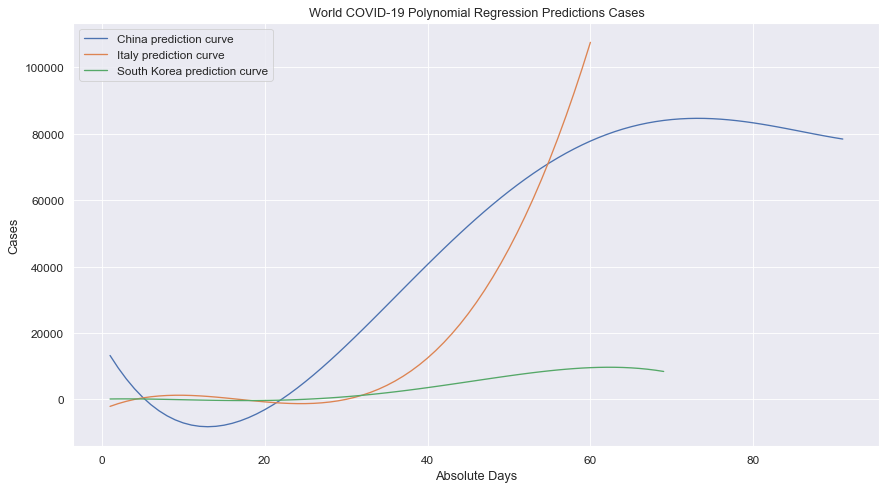

In [92]:
poly_pred_china = poly_reg_china.predict(X_china_poly)
poly_pred_italy = poly_reg_italy.predict(X_italy_poly)
poly_pred_south_korea = poly_reg_south_korea.predict(X_south_korea_poly)

plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_china, poly_pred_china, label="China prediction curve")
plt.plot(X_italy, poly_pred_italy, label="Italy prediction curve")
plt.plot(X_south_korea, poly_pred_south_korea, label="South Korea prediction curve")
plt.title("World COVID-19 Polynomial Regression Predictions Cases")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()


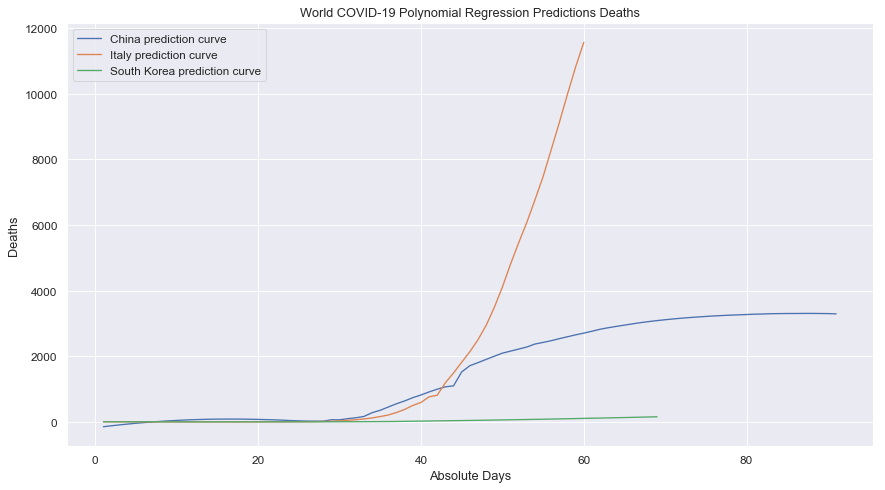

In [93]:
poly_pred_china_deaths = poly_reg_china_deaths.predict(X_china_poly_deaths)
poly_pred_italy_deaths = poly_reg_italy_deaths.predict(X_italy_poly_deaths)
poly_pred_south_korea_deaths = poly_reg_south_korea_deaths.predict(X_south_korea_poly_deaths)


plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_china_deaths.Day, poly_pred_china_deaths, label="China prediction curve")
plt.plot(X_italy_deaths.Day, poly_pred_italy_deaths, label="Italy prediction curve")
plt.plot(X_south_korea_deaths.Day, poly_pred_south_korea_deaths, label="South Korea prediction curve")
plt.title("World COVID-19 Polynomial Regression Predictions Deaths")
plt.xlabel("Absolute Days")
plt.ylabel("Deaths")
plt.legend(loc="upper left")
plt.show()


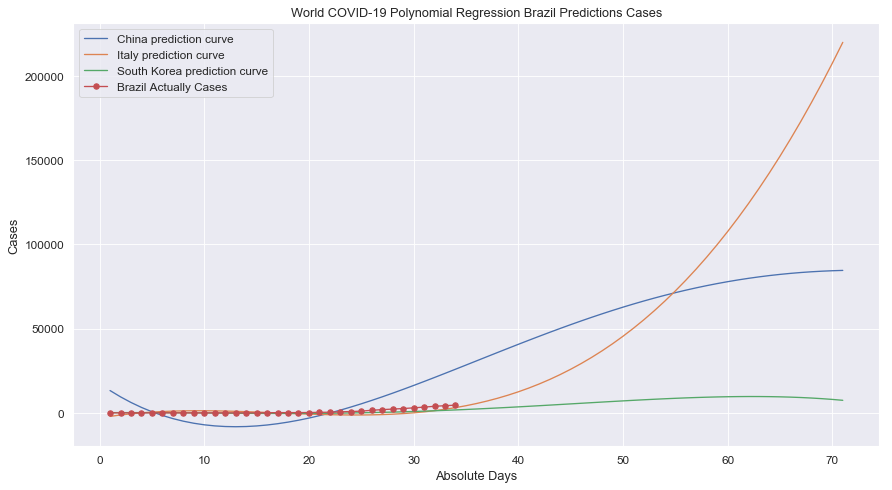

In [94]:
brazil_data_prediction = dfNormDaysBrazil.drop(["Cases","Date","Recovered","Deaths","Contagious"], axis=1).values.reshape(-1, 1)
X_poly_predict = polynomial_features_cases.fit_transform(brazil_data_prediction)

brazil_predict_china = poly_reg_china.predict(X_poly_predict)
brazil_predict_italy = poly_reg_italy.predict(X_poly_predict)
brazil_predict_south_korea = poly_reg_south_korea.predict(X_poly_predict)

plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(brazil_data_prediction, brazil_predict_china, label="China prediction curve")
plt.plot(brazil_data_prediction, brazil_predict_italy, label="Italy prediction curve")
plt.plot(brazil_data_prediction, brazil_predict_south_korea, label="South Korea prediction curve")
plt.plot(dfNormDaysBrazil.Day, dfNormDaysBrazil.Cases, '-o', label="Brazil Actually Cases")
plt.title("World COVID-19 Polynomial Regression Brazil Predictions Cases")
plt.xlabel("Absolute Days")
plt.ylabel("Cases")
plt.legend(loc="upper left")
plt.show()


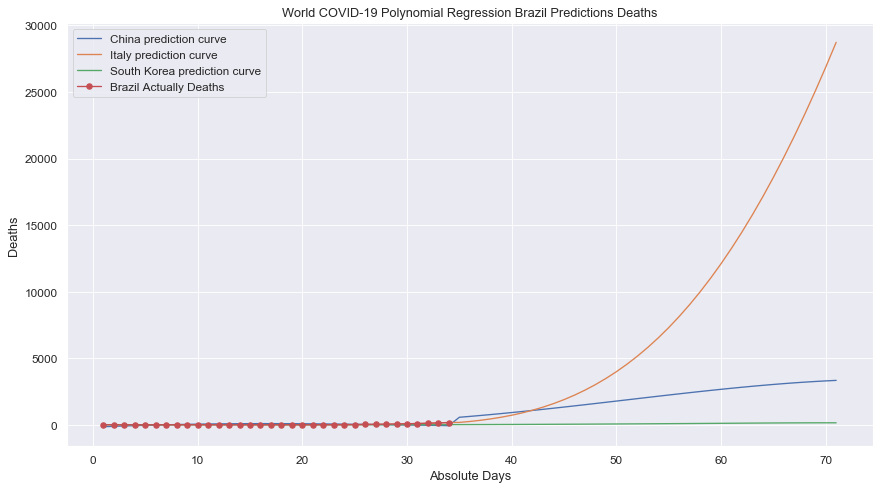

In [95]:
dfNormDaysBrazil = normatization_for_stable_days(dfBrazil, days_to_stable_day)


total_current_cases = len(dfNormDaysBrazil.Cases.values[~np.isnan(dfNormDaysBrazil.Cases.values)])

china_cases_after_prediction = brazil_predict_china[total_current_cases:]
italy_cases_after_prediction = brazil_predict_italy[total_current_cases:]
south_korea_cases_after_prediction = brazil_predict_south_korea[total_current_cases:]

china_concatenate_cases = np.concatenate((dfNormDaysBrazil.Cases.values[~np.isnan(dfNormDaysBrazil.Cases.values)], china_cases_after_prediction))
italy_concatenate_cases = np.concatenate((dfNormDaysBrazil.Cases.values[~np.isnan(dfNormDaysBrazil.Cases.values)], italy_cases_after_prediction))
south_korea_concatenate_cases = np.concatenate((dfNormDaysBrazil.Cases.values[~np.isnan(dfNormDaysBrazil.Cases.values)], south_korea_cases_after_prediction))


dfBrazilChina = normatization_for_stable_days(dfBrazil, days_to_stable_day)
dfBrazilChina.Cases = china_concatenate_cases.astype(int)

dfBrazilItaly = normatization_for_stable_days(dfBrazil, days_to_stable_day)
dfBrazilItaly.Cases = italy_concatenate_cases.astype(int)

dfBrazilSouthKorea = normatization_for_stable_days(dfBrazil, days_to_stable_day)
dfBrazilSouthKorea.Cases = south_korea_concatenate_cases.astype(int)


X_china_brazil_deaths = dfBrazilChina.drop(["Date","Recovered","Deaths","Contagious"], axis=1)
y_china_brazil_deaths = dfBrazilChina.Deaths

X_italy_brazil_deaths = dfBrazilItaly.drop(["Date","Recovered","Deaths","Contagious"], axis=1)
y_italy_brazil_deaths = dfBrazilItaly.Deaths

X_south_brazil_korea_deaths = dfBrazilSouthKorea.drop(["Date","Recovered","Deaths","Contagious"], axis=1)
y_south_brazil_korea_deaths = dfBrazilSouthKorea.Deaths


X_china_brazil_deaths_poly = polynomial_features_deaths.fit_transform(X_china_brazil_deaths)
X_italy_brazil_deaths_poly = polynomial_features_deaths.fit_transform(X_italy_brazil_deaths)
X_south_brazil_korea_deaths_poly = polynomial_features_deaths.fit_transform(X_south_brazil_korea_deaths)

brazil_predict_china_deaths = poly_reg_china_deaths.predict(X_china_brazil_deaths_poly)
brazil_predict_italy_deaths = poly_reg_italy_deaths.predict(X_italy_brazil_deaths_poly)
brazil_predict_south_korea_deaths = poly_reg_south_korea_deaths.predict(X_south_brazil_korea_deaths_poly)

plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfNormDaysBrazil.Day, brazil_predict_china_deaths, label="China prediction curve")
plt.plot(dfNormDaysBrazil.Day, brazil_predict_italy_deaths, label="Italy prediction curve")
plt.plot(dfNormDaysBrazil.Day, brazil_predict_south_korea_deaths, label="South Korea prediction curve")
plt.plot(dfNormDaysBrazil.Day, dfNormDaysBrazil.Deaths, '-o', label="Brazil Actually Deaths")
plt.title("World COVID-19 Polynomial Regression Brazil Predictions Deaths")
plt.xlabel("Absolute Days")
plt.ylabel("Deaths")
plt.legend(loc="upper left")
plt.show()
